# SETUP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
output_dir = 'models/navigation/debug/debug15/' # added sense actions, removed distance reward
debug = False

running job with params {'random_seed': 777, 'job_name': 'null_320726', 'continue_training': False, 'contine_model_at': None, 'contine_config_at': None, 'contine_buffer_at': None, 'overwrite_directory': True, 'map_name': 'AirSimNH', 'rooftops_version': 'v1', 'region': 'all', 'map_resolution_x': 2, 'map_resolution_y': 2, 'map_resolution_z': 4, 'stop_at_invalid': False, 'motion': '2d', 'actions': ['RotateRight', 'RotateLeft', 'MoveForward2', 'MoveForward4', 'MoveForward8', 'MoveForward16', 'MoveForward32'], 'image_sensors': {}, 'nPast': 1, 'id_name': 'alpha', 'vector_sensors': {'SenseActions': True, 'GoalDistanceX': True, 'GoalDistanceY': True, 'SenseDirection': True, 'SenseOrientation': True, 'DistanceBounds': True}, 'vector_length_forget': 6, 'vector_length_remember': 0, 'goal_tolerance': 4, 'astar_multiplier': 2, 'rewards': {'BoundsReward': 1, 'CollisionReward': 1, 'GoalReward': 1, 'MaxStepsReward': 1, 'StepsReward': 0.1}, 'astar_name': 'all', 'astar_version': 'v1', 'level_proba': 0.7

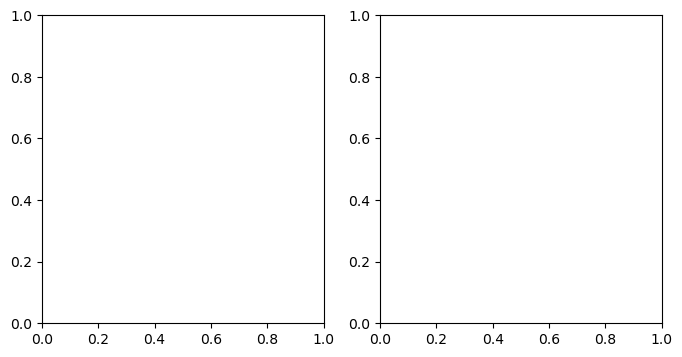

In [2]:
## ** insert this head at top of all main files with your proper paths **
local_dir = '/home/tim/local/' # any local files outside of repo
home_dir = '/home/tim/Dropbox/experimental/' # home directory of repo
import os
os.chdir(home_dir)
import sys
sys.path.append(home_dir)
# optional imports of useful global methods
import utils.global_methods as gm # common utility methods
import map_data.map_methods as mm # data fetching and handling methods
import reinforcement_learning.reinforcement_methods as rm # common overarching methods used for DRL


## local imports
from configuration import Configuration
import random
import numpy as np
initial_locals = locals().copy() # will exclude these parameters from config parameters written to file

## default parameters

# misc
random_seed = 777
job_name = f'null_{random.randint(0, 1_000_000)}'
#output_dir = 'null'
continue_training = False
contine_model_at = None # specify model path to continue training from
contine_config_at = None # specify configuration path to continue training from
contine_buffer_at = None
overwrite_directory = True # True will erase all files at otuput working directory

# environment
map_name = 'AirSimNH'
rooftops_version = 'v1'
region = 'all'
map_resolution_x, map_resolution_y, map_resolution_z = 2, 2, 4
stop_at_invalid = False

# action space
motion = '2d'
actions = [
    'RotateRight',
    'RotateLeft',
    'MoveForward2',
    'MoveForward4',
    'MoveForward8',
    'MoveForward16',
    'MoveForward32',
]
if motion == '3d':
    actions = actions + [
        'MoveDownward4',
        'MoveUpward4',
    ]
    
# observation space
image_sensors = {
    # 'DepthV1':True,
    # 'DepthV2':True,
    # 'DepthV3':True,
}
nPast = 1
id_name = 'alpha' # when reading in observation data, which ID key words to use
vector_sensors = {
    'SenseActions':True,
    'GoalDistanceX':True,
    'GoalDistanceY':True,
    'SenseDirection':True,
    'SenseOrientation':True,
    'DistanceBounds':True,
}
if motion == '3d':
    vector_sensors = vector_sensors + [
        'GoalDistanceZ',
    ]
vector_length_forget = int(np.sum([vector_sensors[name] for name in vector_sensors]))
vector_length_remember = int(np.sum([not vector_sensors[name] for name in vector_sensors]))

# reward function
goal_tolerance = 4
astar_multiplier = 2 # determines max length of an episode
rewards = { # name:weight
    'BoundsReward':1,
    'CollisionReward':1,
    'GoalReward':1,
    'MaxStepsReward':1,
    'StepsReward':.1,
    #'DistanceReward':.1,
}

# levels spawner
astar_name = 'all' # 46812 paths
astar_version = 'v1' 
level_proba = 0.7
split_name = 'train'

# curriculum learning
min_level, max_level = 0, 2 # 0, 9 # index range of path difficulties to train and evaluate on, inclusive
early_freq = 100 # 1_000
early_criteria = 0.8
eval_val_freq = 10*early_freq
eval_train_freq = 10*early_freq
eval_test_freq = 10*early_freq
patience = 10 # number of epochs to wait before triggering early stopping

# DQN policy
net_arch_nodes = 64
net_arch_layers = 2
feature_extractor_scale = 1
feature_extractor_dim = 256
total_policy_scale = 1 # 2
device = 'cuda:0'

# learning algorithm
total_timesteps = 10_000_000 # maximum number of timesteps to train on
    # SB3 default is 1e6, Microsoft uses 5e5
buffer_size = 80_000 # number of recent steps (observation, action, reward) tuples to store in memory to train on -- takes up memory
    # ^^ SB3 default is 1e6, Microsoft uses 5e5, I typically have to use less because of memory constraints
#exploration_fraction =  0.1
stop_annealing = 40_000 # number of steps to stop annealing the exploration rate at
    
# will step through each env.step() and display() and prompt user for input
#debug = True

# read params from command line
#if len(sys.argv) > 1:
#    arguments = gm.parse_arguments(sys.argv[1:])
#    locals().update(arguments)
#assert output_dir!='null', f'output_dir not passed as arg'
gm.set_global('job_name', job_name)
gm.set_global('home_dir', home_dir)
gm.set_global('local_dir', local_dir)
gm.set_global('device', device)
gm.set_random_seed(random_seed)

# set variable subpaths from root directories and params set above
astar_dir = f'{home_dir}map_data/astar_paths/'
observations_dir = f'{home_dir}map_data/observations/'
astar_paths_file = f'{astar_dir}{astar_version}/{map_name}/{motion}/{region}/paths.p'
complete_path = f'{output_dir}completed.p' # path to check if this job is done already
gm.set_global('complete_path', complete_path)

# how to handle if completed path already exists (showing a previous job has finished this data collection already)
if os.path.exists(complete_path):
    if overwrite_directory:
        os.remove(complete_path)
    else:
        gm.progress(job_name, 'complete')
        sys.exit()

# setup output directory
gm.setup_output_dir(output_dir, overwrite_directory)

# bounds drone can move in
datamap = mm.DataMap(map_name, rooftops_version)
gm.set_global('datamap', datamap)
x_bounds, y_bounds, z_bounds = datamap.get_bounds(region, motion)
x_vals = [x for x in range(x_bounds[0], x_bounds[1]+1, map_resolution_x)]
y_vals = [y for y in range(y_bounds[0], y_bounds[1]+1, map_resolution_y)]
z_vals = [z for z in range(z_bounds[0], z_bounds[1]+1, map_resolution_z)]
yaw_vals = [0, 1, 2, 3] # what yaws are accessible by drone
gm.set_global('x_bounds', x_bounds)
gm.set_global('y_bounds', y_bounds)
gm.set_global('z_bounds', z_bounds)

# how astar paths are split into sets and evaluated
eval_frequencies = {}
if eval_train_freq > 0:
    eval_frequencies['train'] = eval_train_freq
if eval_val_freq > 0:
    eval_frequencies['val'] = eval_val_freq
if eval_test_freq > 0:
    eval_frequencies['test'] = eval_test_freq

# misc
exploration_fraction = stop_annealing / total_timesteps
    # SB3 default is 0.1*total_timesteps, Microsoft uses 5e4

# all variables here will be added to configuration parameters for reading later
all_local_vars = locals()
user_local_vars = {k:v for k, v in all_local_vars.items() if (not k.startswith('__') and k not in initial_locals and k not in ['initial_locals','all_local_vars', 'datamap'])}
config_params = user_local_vars.copy() # will include all of the above parameters to config parameters written to file
print('running job with params', config_params)

# COMPONENTS

# continue training will load runs folder and pick up where it left off
# load configuration file and create object to save and connect components
if contine_config_at is None:
    contine_config_at = output_dir + 'configuration.json'
if continue_training and os.path.exists(contine_config_at):
    configuration = Configuration.load(contine_config_at)
    # make controller to run configuration on (we will train a model)
    from controllers.train import Train
    controller = Train(
        model_component = 'Model',
        environment_component = 'Environment',
        continue_training = continue_training,
        total_timesteps = total_timesteps,
        name = 'controller',
        )
    configuration.set_controller(controller)
    for key in config_params:
        configuration.set_parameter(key, config_params[key])
    meta = configuration.meta
    meta['continued_training'] = True
    # read model and/or replay buffer
    # get highest level complete
    modeling_dir = f'{output_dir}modeling/'
    if contine_buffer_at is None:
        contine_buffer_at = f'{modeling_dir}replay_buffer.zip'
    if contine_model_at is None:
        final_model_path = f'{modeling_dir}model_eval.zip'
    model_component = configuration.get_component('Model')
    model_component.read_model_path = contine_model_at
    model_component.read_replay_buffer_path = contine_buffer_at
    gm.speak('continuing training...')

# if not continuing training then make a brand spaking new config
else:
    # set meta data (anything you want here, just writes to config file as a dict)
    meta = {
        }

    ## make a new configuration file to add components to 
        # this obj will be used to serialize components, and log experiment history
        # any components created after making this configuration file will auto be added to it
        # components use the name of other components which will be created and connected later
        # this is done to handle different objects which need to be connected to eachother and connected in different orders
        # there is a baked in priority que for connecting components if you need to handle this differently
    configuration = Configuration(meta, add_timers=True)
    # make controller to run configuration on (we will train a model)
    from controllers.train import Train
    controller = Train(
        model_component = 'Model',
        environment_component = 'Environment',
        continue_training = continue_training,
        total_timesteps = total_timesteps,
        name = 'controller',
        )
    configuration.set_controller(controller)
    for key in config_params:
        configuration.set_parameter(key, config_params[key])

    ## create environment component to handle step() and reset() for DRL model training
    from environments.goalenv import GoalEnv
    goal_env = GoalEnv(
        drone_component = 'Drone', 
        actor_component = 'Actor', 
        observer_component = 'Observer', 
        rewarder_component = 'Rewarder',
        model_component = 'Model',
        map_component = 'Map',
        spawner_component = 'Spawner',
        crash_handler = False,
        debug = debug,
        name = 'Environment',
        )

    # create map object
    from maps.datamap import DataMap
    DataMap(
        name = 'Map',
        x_bounds = x_bounds,
        y_bounds = y_bounds,
        z_bounds = z_bounds,
        )

    # drone controller component - we will use AirSim
        # this can also be real world drone controller like Tello
    from drones.etherial import Etherial
    Etherial(
        map_component = 'Map',
        stop_at_invalid = stop_at_invalid,
        name = 'Drone',
        )

    ## REWARD FUNCTION
    # we will reward moving closer, reward reaching goal, penalize too many steps, and penalize collisions
    # heavy penalty for out of bounds
    if 'BoundsReward' in rewards:
        from rewards.bounds import Bounds
        Bounds(
            drone_component = 'Drone',
            x_bounds = x_bounds,
            y_bounds = y_bounds,
            z_bounds = z_bounds,
            name = 'BoundsReward',
            )
    # heavy penalty for collision
    if 'CollisionReward' in rewards:
        from rewards.collision import Collision
        Collision(
            drone_component = 'Drone',
            name = 'CollisionReward',
            )
    # heavy reward for reaching goal
    if 'GoalReward' in rewards:
        from rewards.goal import Goal
        Goal(
            drone_component = 'Drone',
            goal_component = 'Spawner',
            include_z = True if motion in '3d' else False, # includes z in distance calculations
            tolerance = goal_tolerance, # must reach goal within this many meters
            terminate = True, # we are terminating this example when the drone realizes it reached the goal, collides, or reaches max
            name = 'GoalReward',
            )
    # heavy penalty for using too many steps
    if 'MaxStepsReward' in rewards:
        from rewards.maxsteps import MaxSteps
        MaxSteps(
            spawner_component = 'Spawner',
            use_astar = True, # bases max steps based on astar length
            astar_multiplier = astar_multiplier, # max step size is this many times the astar length
            name = 'MaxStepsReward',
            )
    # intermediate penalty for using more steps
    if 'StepsReward' in rewards:
        from rewards.steps import Steps
        Steps(
            name = 'StepsReward',
            )
    # intermediate reward for approaching goal
    if 'DistanceReward' in rewards:
        from rewards.distance import Distance
        Distance(
            drone_component = 'Drone',
            goal_component = 'Spawner',
            include_z = True if motion in '3d' else False, # includes z in distance calculations
            name = 'DistanceReward',
            )
    # REWARDER
    from rewarders.schema import Schema
    Schema(
        rewards_components = list(rewards.keys()),
        reward_weights = [rewards[name] for name in rewards], 
        name = 'Rewarder',
        )

    ## ACTION SPACE
    # we will just move forward and rotate for this example
    from actions.object import Object 
    if 'RotateRight' in actions:
        Object(
            object_component = 'Drone',  
            action_name = 'rotate_right',
            name = 'RotateRight',
            )
    if 'RotateLeft' in actions:
        Object(
            object_component = 'Drone',  
            action_name = 'rotate_left',
            name = 'RotateLeft',
            )
    if 'MoveForward2' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_forward',
            action_params = {'magnitude':2},
            name = 'MoveForward2',
            )
    if 'MoveForward4' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_forward',
            action_params = {'magnitude':4},
            name = 'MoveForward4',
            )
    if 'MoveForward8' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_forward',
            action_params = {'magnitude':8},
            name = 'MoveForward8',
            )
    if 'MoveForward16' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_forward',
            action_params = {'magnitude':16},
            name = 'MoveForward16',
            )
    if 'MoveForward32' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_forward',
            action_params = {'magnitude':32},
            name = 'MoveForward32',
            )
    if 'MoveDownward4' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_downward',
            action_params = {'magnitude':4},
            name = 'MoveDownward4',
            )
    if 'MoveUpward4' in actions:
        Object(
            object_component = 'Drone', 
            action_name = 'move_upward',
            action_params = {'magnitude':4},
            name = 'MoveUpward4',
            )

    ## ACTOR
    from actors.discrete import Discrete
    Discrete(
        actions_components = actions,
        name = 'Actor',
        )

    ## OBSERVATION SPACE
    # TRANSFORMERS
    from transformers.normalize import Normalize
    Normalize(
        min_input = 0, # min direction
        max_input = 3, # max direction
        name = 'NormalizeDirection',
        )
    Normalize(
        min_input = 0, # min angle
        max_input = 2*np.pi, # max angle
        name = 'NormalizeOrientation',
        )
    Normalize(
        min_input = 0, # 
        max_input = 255, # horizon
        name = 'NormalizeDistance',
        )
    
    # SENSORS
    # sense last action(s) taken
    if 'SenseActions' in vector_sensors:
        from sensors.actions import Actions
        Actions(
            actor_component = 'Actor',
            prefix = 'actions',
            transformers_components = [], 
            name = 'SenseActions',
            )
    # sense x distance to goal
    if 'GoalDistanceX' in vector_sensors:
        from sensors.distance import Distance
        Distance(
            misc_component = 'Drone',
            misc2_component = 'Spawner',
            include_x = True,
            include_y = False,
            include_z = False,
            prefix = 'x_distance',
            transformers_components = [
                'NormalizeDistance',
                ], 
            name = 'GoalDistanceX',
            )
    # sense y distance to goal
    if 'GoalDistanceY' in vector_sensors:
        from sensors.distance import Distance
        Distance(
            misc_component = 'Drone',
            misc2_component = 'Spawner',
            include_x = False,
            include_y = True,
            include_z = False,
            prefix = 'y_distance',
            transformers_components = [
                'NormalizeDistance',
                ], 
            name = 'GoalDistanceY',
            )
    # sense current drone direction
    if 'SenseDirection' in vector_sensors:
        from sensors.direction import Direction
        Direction(
            drone_component = 'Drone',
            transformers_components = [
                'NormalizeDirection',
                ],
            name = 'SenseDirection',
        )
    # sense angle between current pos and target pos
    if 'SenseOrientation' in vector_sensors:
        from sensors.orientation import Orientation
        Orientation(
            misc_component = 'Drone',
            misc2_component = 'Spawner',
            transformers_components = [
                'NormalizeOrientation',
                ],
            name = 'SenseOrientation',
        )
    # sense distance to bounds in front of drone
    if 'DistanceBounds' in vector_sensors:
        from sensors.distancebounds import DistanceBounds
        DistanceBounds(
            drone_component = 'Drone',
            x_bounds = x_bounds,
            y_bounds = y_bounds,
            z_bounds = z_bounds,
            include_z = True if motion in '3d' else False,
            transformers_components = [
                'NormalizeDistance',
                ],
            name = 'DistanceBounds',
        )
    # sense vert distance to goal
    if 'GoalDistanceZ' in vector_sensors:
        from sensors.distance import Distance
        Distance(
            misc_component = 'Drone',
            misc2_component = 'Spawner',
            include_x = False,
            include_y = False,
            include_z = True,
            prefix = 'z_distance',
            transformers_components = [
                'NormalizeDistance',
                ], 
            name = 'GoalDistanceZ',
            )
    if len(image_sensors) > 0:
        image_bands_remember = 0
        image_bands_forget = 0
        for sensor_name in image_sensors:
            sensor_info = gm.read_json(f'{observations_dir}{sensor_name}/info.json')
            image_bands, image_height, image_width = sensor_info['array_size']
            # single sensor
            from sensors.datamap import DataMap
            DataMap(
                drone_component = 'Drone',
                sensor_name = sensor_name,
                sensor_dir = f'{observations_dir}{sensor_name}/',
                transformers_components=[],
                name = sensor_name,
            )
            if image_sensors[sensor_name]:
                image_bands_remember += image_bands
            else:
                image_bands_forget += image_bands
        # OBSERVER
        # currently must count vector size of sensor output
        from observers.single import Single
        Single(
            sensors_components = vector_sensors,
            vector_length_forget = vector_length_forget,
            vector_length_remember = vector_length_remember,
            nPast = nPast,
            null_if_in_obj = True, # inside an object
            null_if_oob = True, # out of bounds
            name = 'VecObserver',
            )
        Single(
            sensors_components = [name for name in image_sensors], 
            is_image = True,
            image_height = image_height, 
            image_width = image_width,
            image_bands_forget = image_bands_forget,
            image_bands_remember = image_bands_remember,
            nPast = nPast,
            null_if_in_obj = True, # inside an object
            null_if_oob = True, # out of bounds
            name = 'ImgObserver',
            )
        from observers.multi import Multi
        Multi(
            vector_observer_component = 'VecObserver',
            image_observer_component = 'ImgObserver',
            name = 'Observer',
            )
        ## MODEL
            # we will use a TD3 algorithm from SB3
        from sb3models.dqn import DQN
        DQN(
            environment_component = 'Environment',
            policy = 'MultiInputPolicy',
            buffer_size = buffer_size,
            device = device,
            exploration_fraction = exploration_fraction,
            # calling custom methods for 3rd party libraries is messy
            # note that the _class features are strings to make them json configuration compatidble
            # I wrote a str_to_class() method in sb3model to adjust for this by converting to class at run time
            policy_kwargs = {
                'net_arch':[int(total_policy_scale*net_arch_nodes) for _ in range(net_arch_layers)],
                'features_extractor_class':'CombinedExtractor_tim', # CombinedExtractor_tim
                'features_extractor_kwargs':{
                    'cnn_output_dim':int(total_policy_scale*feature_extractor_dim),
                    'normalized_image':False,
                    'tim_cnn_class':'NatureCNN_tim', # NatureCNN_tim
                    'tim_cnn_kwargs':{
                        'scale':total_policy_scale*feature_extractor_scale,
                    },
                },
            },
            name = 'Model',
        )
    else:
        # currently must count vector size of sensor output
        from observers.single import Single
        Single(
            sensors_components = [name for name in vector_sensors],
            vector_length_forget = vector_length_forget,
            vector_length_remember = vector_length_remember,
            nPast = nPast,
            null_if_in_obj = True, # inside an object
            null_if_oob = True, # out of bounds
            name = 'Observer',
            )
        ## MODEL
            # we will use a TD3 algorithm from SB3
        from sb3models.dqn import DQN
        DQN(
            environment_component = 'Environment',
            policy = 'MlpPolicy',
            buffer_size = buffer_size,
            device = device,
            exploration_fraction = exploration_fraction,
            # calling custom methods for 3rd party libraries is messy
            # note that the _class features are strings to make them json configuration compatidble
            # I wrote a str_to_class() method in sb3model to adjust for this by converting to class at run time
            policy_kwargs = {
                'net_arch':[int(total_policy_scale*net_arch_nodes) for _ in range(net_arch_layers)],
            },
            name = 'Model',
        )



    # SPAWNER
        # moves drone to desired starting location
        # sets the target goal since it is typically dependent on the start location
    from spawners.levels import Levels            
    Levels(
        drone_component = 'Drone',
        levels_path = astar_paths_file,
        min_level = min_level,
        max_level = max_level,
        split_name = 'train',
        level_proba = level_proba,
        name = 'Spawner',
    )

    ## MODIFIERS
        # modifiers are like wrappers, and will add functionality before or after any component
    # CURRICULUM LEARNING
        # this modifier will be called at the end of every episode to see the percent of succesfull paths
        # if enough paths were succesfull then this will level up to harder goal
    from modifiers.curriculum import Curriculum
    Curriculum(
        base_component = 'Environment',
        parent_method = 'end',
        order = 'post',
        spawner_component = 'Spawner', # which component to level up
        model_component = 'Model',
        min_level = min_level, # will start at this level unless specified with level argument
        max_level = max_level, # can level up this many times after will terminate DRL learning loop
        eval_controller_component = 'EvalController',
        update_progress = True,
        eval_frequencies = eval_frequencies,
        use_early = True,
        early_freq = early_freq,
        early_criteria = early_criteria,
        patience = patience,
        view_progress = True,
        name = 'Curriculum',
    )

    # val/test components
    # ENVIRONMENT
    GoalEnv(
        drone_component = 'Drone', 
        actor_component = 'Actor', 
        observer_component = 'Observer', 
        rewarder_component = 'Rewarder',
        model_component = 'Model',
        map_component = 'Map',
        spawner_component = 'Spawner',
        crash_handler = False,
        name = 'EnvironmentVal',
        )
    # SAVERS - save observations and/or states at each step
    from others.eval import Eval
    Eval(
        environment_component = 'EnvironmentVal',
        model_component = 'Model',
        spawner_component = 'Spawner',
        name = 'EvalController'
    )

    if debug:
        goal_env._nPast = nPast
        goal_env._reward_names = rewards
        goal_env._vector_sensor_names = vector_sensors

In [3]:
# CONNECT COMPONENTS
configuration.connect_all()
gm.speak('all components connected...')

connected component with name Actor
connected component with name Map
connected component with name Drone
connected component with name BoundsReward
connected component with name CollisionReward
connected component with name GoalReward
connected component with name MaxStepsReward
connected component with name StepsReward
connected component with name Rewarder
connected component with name RotateRight
connected component with name RotateLeft
connected component with name MoveForward2
connected component with name MoveForward4
connected component with name MoveForward8
connected component with name MoveForward16
connected component with name MoveForward32
connected component with name NormalizeDirection
connected component with name NormalizeOrientation
connected component with name NormalizeDistance
connected component with name Spawner
connected component with name EvalController
connected component with name SenseActions
connected component with name GoalDistanceX
connected component 

In [4]:
# WRITE CONFIGURATION
configuration.save()

In [5]:
# WRITE CONTROLLER
controller.save(output_dir + 'train_controller.json')

In [6]:
for i, action in enumerate(actions):
    print(i, action)

0 RotateRight
1 RotateLeft
2 MoveForward2
3 MoveForward4
4 MoveForward8
5 MoveForward16
6 MoveForward32


In [7]:
configuration.get_component('Spawner')._n_split_paths

800

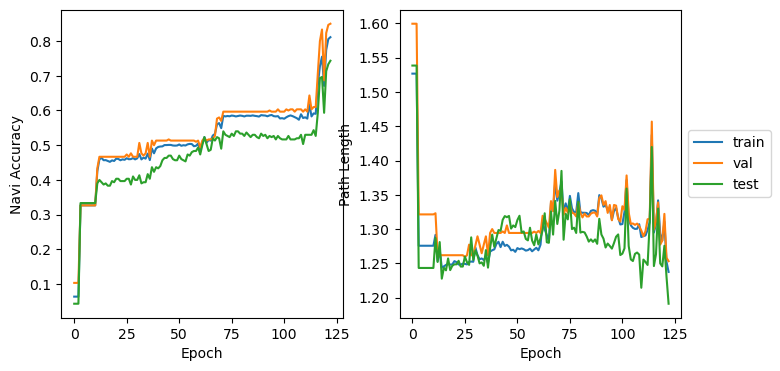

lvl-2 eps-123000 Test-0.73 early-0.82 chk-True wait-10 train-81.12% val-85.00% test-74.33% eval_time-0.13min train_time-0.14min
max level reached, 2


<Figure size 640x480 with 0 Axes>

In [8]:
# RUN CONTROLLER
gm.speak('running controller...')
configuration.controller.run()

In [9]:
# DISCONNECT
configuration.disconnect_all()

In [10]:
# done
gm.speak('training complete! evaluating...')
configuration.save()

training complete! evaluating...


In [11]:
configuration.benchmarks['time'].keys()

dict_keys(['units', 'actors.actor.connect', 'maps.map.connect', 'drones.drone.connect', 'rewards.reward.connect', 'rewarders.rewarder.connect', 'actions.action.connect', 'transformers.transformer.connect', 'spawners.levels.set_level', 'spawners.levels.set_active_split', 'spawners.levels.connect', 'others.eval.connect', 'sensors.actions.connect', 'sensors.sensor.connect', 'sensors.distancebounds.connect', 'component.connect', 'observers.single.get_space', 'actors.discrete.get_space', 'environments.goalenv.connect', 'stable_baselines3.dqn.dqn.DQN', 'sb3models.sb3model.connect', 'modifiers.curriculum.connect', 'environments.goalenv.reset_learning', 'component.reset_learning', 'spawners.levels.reset_rotating', 'spawners.levels.reset_learning', 'modifiers.curriculum.reset_level', 'modifiers.curriculum.reset_early', 'modifiers.curriculum.reset_criterias', 'modifiers.curriculum.reset_learning', 'sb3models.sb3model.reset', 'component.reset', 'drones.etherial.check_collision', 'drones.etherial.

In [12]:
times = configuration.benchmarks['time']

for key in times:
    if key in ['units']:
        continue
    total_time = round(np.sum(times[key])*1e-6,2)
    print(key, total_time)

actors.actor.connect 0.0
maps.map.connect 0.0
drones.drone.connect 0.0
rewards.reward.connect 0.0
rewarders.rewarder.connect 0.0
actions.action.connect 0.0
transformers.transformer.connect 0.0
spawners.levels.set_level 0.04
spawners.levels.set_active_split 0.05
spawners.levels.connect 0.5
others.eval.connect 0.0
sensors.actions.connect 0.0
sensors.sensor.connect 0.0
sensors.distancebounds.connect 0.0
component.connect 0.0
observers.single.get_space 0.0
actors.discrete.get_space 0.0
environments.goalenv.connect 0.0
stable_baselines3.dqn.dqn.DQN 1.21
sb3models.sb3model.connect 1.21
modifiers.curriculum.connect 0.0
environments.goalenv.reset_learning 0.0
component.reset_learning 0.0
spawners.levels.reset_rotating 0.0
spawners.levels.reset_learning 0.0
modifiers.curriculum.reset_level 0.0
modifiers.curriculum.reset_early 0.0
modifiers.curriculum.reset_criterias 0.0
modifiers.curriculum.reset_learning 0.0
sb3models.sb3model.reset 0.25
component.reset 1.9
drones.etherial.check_collision 1.04

In [13]:
rm.evaluate_navi({
    'config_path':f'{output_dir}configuration.json',
    'model_path':f'{output_dir}modeling/model_eval.zip',
    'output_dir':f'{output_dir}train_final/',
    'device':device,
    'min_level':min_level,
    'max_level':max_level,
    'split_name':'train',
})

config_path models/navigation/debug/debug15/configuration.json
model_path models/navigation/debug/debug15/modeling/model_eval.zip
output_dir models/navigation/debug/debug15/train_final/
device cuda:0
min_level 0
max_level 2
split_name train
running job with params {'job_name': None, 'map_name': 'AirSimNH', 'rooftops_version': 'V1', 'region': 'all', 'motion': '2d', 'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/train_final/', 'split_name': 'train', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'overwrite_directory': False, 'random_seed': 42, 'save_states': True, 'arguments': {'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/train_final/', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'split_name': 

(0.72125, 1.1634893125361063)

In [14]:
rm.evaluate_navi({
    'config_path':f'{output_dir}configuration.json',
    'model_path':f'{output_dir}modeling/model_eval.zip',
    'output_dir':f'{output_dir}val_final/',
    'device':device,
    'min_level':min_level,
    'max_level':max_level,
    'split_name':'val',
})

config_path models/navigation/debug/debug15/configuration.json
model_path models/navigation/debug/debug15/modeling/model_eval.zip
output_dir models/navigation/debug/debug15/val_final/
device cuda:0
min_level 0
max_level 2
split_name val
running job with params {'job_name': None, 'map_name': 'AirSimNH', 'rooftops_version': 'V1', 'region': 'all', 'motion': '2d', 'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/val_final/', 'split_name': 'val', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'overwrite_directory': False, 'random_seed': 42, 'save_states': True, 'arguments': {'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/val_final/', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'split_name': 'val'}, 'x

(0.77, 1.1893939393939392)

In [15]:
rm.evaluate_navi({
    'config_path':f'{output_dir}configuration.json',
    'model_path':f'{output_dir}modeling/model_eval.zip',
    'output_dir':f'{output_dir}test_final/',
    'device':device,
    'min_level':min_level,
    'max_level':max_level,
    'split_name':'test',
})

config_path models/navigation/debug/debug15/configuration.json
model_path models/navigation/debug/debug15/modeling/model_eval.zip
output_dir models/navigation/debug/debug15/test_final/
device cuda:0
min_level 0
max_level 2
split_name test
running job with params {'job_name': None, 'map_name': 'AirSimNH', 'rooftops_version': 'V1', 'region': 'all', 'motion': '2d', 'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/test_final/', 'split_name': 'test', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'overwrite_directory': False, 'random_seed': 42, 'save_states': True, 'arguments': {'config_path': 'models/navigation/debug/debug15/configuration.json', 'model_path': 'models/navigation/debug/debug15/modeling/model_eval.zip', 'output_dir': 'models/navigation/debug/debug15/test_final/', 'device': 'cuda:0', 'min_level': 0, 'max_level': 2, 'split_name': 'test

(0.7433333333333333, 1.1911808669656203)

In [16]:
gm.print_local_log()
gm.pk_write(True, complete_path)
gm.progress(job_name, f'complete')

In [17]:
# def display_step(prev_obs_data, initial_state, previous_state, state, path, df):
#     step = state['nSteps']
#     print()
#     print(f'state at timestep {step}')
#     img = prev_obs_data['img']
#     vec = prev_obs_data['vec']
#     ncols = nPast
#     fig, axs = plt.subplots(ncols=ncols, figsize=(10, 5))
#     for t in range(nPast):
#         ax = axs[t]
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_title(f'{sensor_name} @ t-{t}')
#         ax.imshow(img[t])
#     #plt.suptitle(f't = {step}')
#     plt.tight_layout()
#     plt.show()    
    
#     j = 0
#     for t in range(nPast):
#         for i, vec_sensor in enumerate(vector_sensors):
#             df[vec_sensor][t] = round(vec[j], 4)
#             j += 1
#     for t in range(nPast-1, 0, -1):
#         for i, reward in enumerate(rewards):
#             df[reward][t] = df[reward][t-1]
#         df['action'][t] = df['action'][t-1]
#     for i, reward in enumerate(rewards):
#         if f'reward_from_{reward}' in state:
#             df[reward][0] = round(state[f'reward_from_{reward}'], 4)
#         else:
#             df[reward][0] = '-'
#     df['action'][0] = state['transcribed_action']
#     pdf = pd.DataFrame(df)
#     pdf.index.name = 't'
#     display(pdf)

#     # fig, ax = plt.subplots()
#     # ax.table(cellText=pdf.values, colLabels=pdf.columns, cellLoc='center', loc='center')
#     # plt.show()
    
#     fig, ax = plt.subplots(figsize=(4, 4))
#     start_pos = initial_state['drone_position']
#     goal_pos = initial_state['goal_position']
#     drone_pos = previous_state['drone_position']
#     direction = previous_state['direction']
#     datamap.view_map(fig, ax, x=drone_pos[0], y=drone_pos[1], z=drone_pos[2], direction=direction, 
#                  start=start_pos, target=goal_pos, path=path, show_z=False, resolution=None)
#     ax.set_title(f'{start_pos} to {goal_pos}')
#     plt.show()

In [18]:
## env = configuration.get_component('Environment')
# model = configuration.get_component('Model')

# df = {}
# df['action'] = ['-']*nPast
# for vec_sensor in vector_sensors:
#     df[vec_sensor] = [0]*nPast
# for reward in rewards:
#     df[reward] = ['-']*nPast

# # reset environment, returning first observation
# path = []
# observation_data, initial_state = env.reset()
# previous_state = initial_state
# prev_obs_data = observation_data
# # start episode
# done = False
# reward_vals = []
# gamma = 0.99
# while(not done):
#     rl_output = model.predict(observation_data)
#     # take next step
#     observation_data, reward, done, truncated, state = env.step(rl_output)
#     reward_vals.append(reward)
#     display_step(prev_obs_data, initial_state, previous_state, state, path, df)
#     path.append(state['drone_position'])
#     previous_state = state
#     prev_obs_data = observation_data
# q = 0
# for i, reward in enumerate(reward_vals):
#     q += reward * gamma**(len(reward_vals)-i-1)
# length = (1+len(rewards)) / initial_state['astar_length']
# # end of episode
# if 'reached_goal' not in state or 'termination_reason' not in state:
#     print( False, 'unknown', q, np.nan)
# print( state['reached_goal'], state['termination_reason'], q, length)